<a href="https://colab.research.google.com/github/zyf2021/-/blob/main/CNN_2_class_HPO_TUNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



1.   Перечитать хандбук 
2.   Новый пункт

In [ ]:
from functools import partial
def multiply(x,y):
    return x * y

partial_func = partial(multiply,5) 
partial_func

20

In [ ]:
!pip install -U "ray[default]"

In [71]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader
import torch.nn.functional as F

try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary

from ray import air, tune
from ray.air import session
from ray.tune.schedulers import ASHAScheduler



In [61]:
class Net(nn.Module):
    def __init__(self, out_channels = 2, l1=120, l2=84):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, 
                               out_channels = 6, 
                               kernel_size = 5)
        self.pool = nn.MaxPool2d(kernel_size=2,
                                 stride=2)
        self.conv2 = nn.Conv2d(in_channels = 6, 
                               out_channels = 20, 
                               kernel_size = 5)
        self.fc1 = nn.Linear(in_features=20*5*5, ### должно прийти такое значение
                             out_features=l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, out_channels)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape) # torch.Size([1, 16, 5, 5])
        x = x.view(-1, 20 * 5 * 5) # reshape tensor x for exmp from 1x16 to 4x4, -1 for unknown numbers of row
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_0 = Net()
model_0
summary(model_0, [1, 3, 32, 32]) # do a test pass through of an example input size 

/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.10/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 2]                    --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─MaxPool2d: 1-2                         [1, 6, 14, 14]            --
├─Conv2d: 1-3                            [1, 20, 10, 10]           3,020
├─MaxPool2d: 1-4                         [1, 20, 5, 5]             --
├─Linear: 1-5                            [1, 120]                  60,120
├─Linear: 1-6                            [1, 84]                   10,164
├─Linear: 1-7                            [1, 2]                    170
Total params: 73,930
Trainable params: 73,930
Non-trainable params: 0
Total mult-adds (M): 0.73
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.30
Estimated Total Size (MB): 0.36

In [62]:

# Change these values if you want the training to run quicker or slower.
EPOCH_SIZE = 512
TEST_SIZE = 256

def train(model, optimizer, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # We set this just for the example to run quickly.
        if batch_idx * len(data) > EPOCH_SIZE:
            return
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()


def test(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            # We set this just for the example to run quickly.
            if batch_idx * len(data) > TEST_SIZE:
                break
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

In [27]:
# подключение гугл диска, на котором хранится zip-архив с датасетом
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [28]:
import zipfile
from pathlib import Path

In [29]:
#  Установить пути к папке с данными. 
image_path = Path('/content/WineYardDataset')

if image_path.is_dir():
  print(f"{image_path} папка для распаковки датасета существует")
else:
  print(f"{image_path} не существует, создана новая папка ...")
  image_path.mkdir(parents = True, exist_ok = True)

  #  здесь могла бы быть загрузка файла, но файл итак на гугл диске, поэтому
  #  можно дописать в случае необходимости и библиотеки request

  #  Распаковка архива
  with zipfile.ZipFile("/content/drive/MyDrive/Виноградники/Dataset.zip", "r") as zip_ref:
    print("Распаковка...")
    zip_ref.extractall(image_path)

/content/WineYardDataset не существует, создана новая папка ...
Распаковка...


In [30]:
image_path = Path('/content/WineYardDataset/Dataset')

In [31]:
import os

In [63]:
def train_wine(config):
    # Data Setup
    image_path = Path('/content/WineYardDataset/Dataset')
    data_transformation = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Resize(size = (32, 32)),
         transforms.Normalize((0.1307, ), (0.3081, ))])
    
    train_dir = image_path / "train"
    test_dir = image_path / "test"
    train_data = datasets.ImageFolder(root = train_dir,
                                      transform = data_transformation,
                                      target_transform = None)

    test_data = datasets.ImageFolder(root = test_dir,
                                    transform=data_transformation)

    class_names = train_data.classes
    class_dict = train_data.class_to_idx

    BATCH_SIZE = 32
    NUM_WORKERS = os.cpu_count()
    train_dataloader = DataLoader(dataset=train_data, 
                                  batch_size=BATCH_SIZE, # как много кадров в батче
                                  num_workers=NUM_WORKERS, # как много процессов использовать для работы
                                  shuffle=True) # перемешать данные

    test_dataloader = DataLoader(dataset=test_data, 
                                batch_size=BATCH_SIZE, 
                                num_workers=NUM_WORKERS, 
                                shuffle=False) # don't usually need to shuffle testing data
    print(f"Создание DataLoaders с batch: {BATCH_SIZE} и workers: {NUM_WORKERS}.")
    img, label = next(iter(train_dataloader))

    # Batch size - это первое число
    print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
    print(f"Label shape: {label.shape}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = Net()
    model.to(device)

    optimizer = optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])
    for i in range(10):
        train(model, optimizer, train_dataloader)
        acc = test(model, test_dataloader)

        # Send the current training result back to Tune
        session.report({"mean_accuracy": acc})

        if i % 5 == 0:
            # This saves the model to the trial directory
            torch.save(model.state_dict(), "/content/models_state_dict.pth")

In [64]:
search_space = {
    "lr": tune.sample_from(lambda spec: 10 ** (-10 * np.random.rand())),
    "momentum": tune.uniform(0.1, 0.9),
}

# Uncomment this to enable distributed execution
# `ray.init(address="auto")`

# Download the dataset first
#datasets.MNIST("~/data", train=True, download=True)

tuner = tune.Tuner(
    train_wine,
    param_space=search_space,
)
results = tuner.fit()

2023-05-04 22:41:01,101	WARNING callback.py:142 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


(train_wine pid=24900) Создание DataLoaders с batch: 32 и workers: 2.


(train_wine pid=24900) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 5x across cluster]
(train_wine pid=24900)   warnings.warn( [repeated 5x across cluster]


(train_wine pid=24900) Image shape: torch.Size([32, 3, 32, 32]) -> [batch_size, color_channels, height, width]
(train_wine pid=24900) Label shape: torch.Size([32])


Trial name,date,done,experiment_tag,hostname,iterations_since_restore,mean_accuracy,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
train_wine_bea41_00000,2023-05-04_22-41-58,True,0_momentum=0.6456,fb1f0caed0b8,10,1,172.28.0.12,24900,53.908,4.34177,53.908,1683240118,10,bea41_00000


(train_wine pid=24900) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(train_wine pid=24900)   warnings.warn( [repeated 6x across cluster]
(train_wine pid=24900) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizi

[<Axes: >]

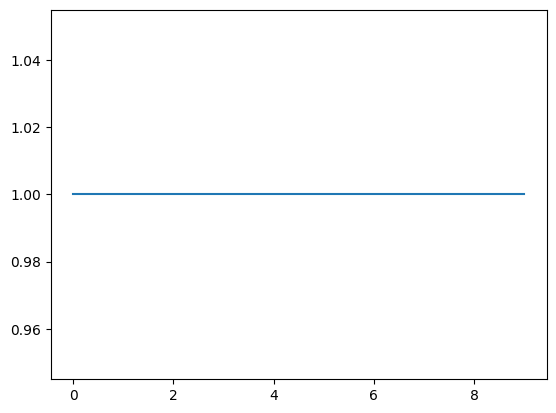

In [65]:
dfs = {result.log_dir: result.metrics_dataframe for result in results}
[d.mean_accuracy.plot() for d in dfs.values()]

In [66]:
tuner = tune.Tuner(
    train_wine,
    tune_config=tune.TuneConfig(
        num_samples=20,
        scheduler=ASHAScheduler(metric="mean_accuracy", mode="max"),
    ),
    param_space=search_space,
)
results = tuner.fit()

# Obtain a trial dataframe from all run trials of this `tune.run` call.
dfs = {result.log_dir: result.metrics_dataframe for result in results}

2023-05-04 22:43:13,561	WARNING callback.py:142 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


(train_wine pid=26017) Создание DataLoaders с batch: 32 и workers: 2.


(train_wine pid=26017) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 4x across cluster]
(train_wine pid=26017)   warnings.warn( [repeated 4x across cluster]


(train_wine pid=26017) Image shape: torch.Size([32, 3, 32, 32]) -> [batch_size, color_channels, height, width]
(train_wine pid=26017) Label shape: torch.Size([32])


(train_wine pid=26017) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 4x across cluster]
(train_wine pid=26017)   warnings.warn( [repeated 4x across cluster]


(train_wine pid=26111) Создание DataLoaders с batch: 32 и workers: 2.


Trial name,date,done,experiment_tag,hostname,iterations_since_restore,mean_accuracy,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
train_wine_0d97d_00000,2023-05-04_22-45-25,True,0_momentum=0.8850,fb1f0caed0b8,10,1,172.28.0.12,26017,126.901,11.9248,126.901,1683240325,10,0d97d_00000
train_wine_0d97d_00001,2023-05-04_22-45-38,True,1_momentum=0.8782,fb1f0caed0b8,10,1,172.28.0.12,26111,131.993,9.1559,131.993,1683240338,10,0d97d_00001
train_wine_0d97d_00002,2023-05-04_22-45-37,True,,fb1f0caed0b8,1,0,172.28.0.12,26017,11.7821,11.7821,11.7821,1683240337,1,0d97d_00002
train_wine_0d97d_00003,2023-05-04_22-47-47,True,3_momentum=0.4098,fb1f0caed0b8,10,1,172.28.0.12,26017,130.164,12.6465,130.164,1683240467,10,0d97d_00003
train_wine_0d97d_00004,2023-05-04_22-45-52,True,,fb1f0caed0b8,1,0,172.28.0.12,26111,14.4836,14.4836,14.4836,1683240352,1,0d97d_00004
train_wine_0d97d_00005,2023-05-04_22-48-03,True,5_momentum=0.6175,fb1f0caed0b8,10,1,172.28.0.12,26111,130.398,13.6346,130.398,1683240483,10,0d97d_00005
train_wine_0d97d_00006,2023-05-04_22-49-55,True,6_momentum=0.4208,fb1f0caed0b8,10,1,172.28.0.12,26017,127.616,13.7329,127.616,1683240595,10,0d97d_00006
train_wine_0d97d_00007,2023-05-04_22-50-06,True,7_momentum=0.8773,fb1f0caed0b8,10,1,172.28.0.12,26111,123.209,9.95928,123.209,1683240606,10,0d97d_00007
train_wine_0d97d_00008,2023-05-04_22-51-56,True,8_momentum=0.4108,fb1f0caed0b8,10,1,172.28.0.12,26017,121,11.3898,121,1683240716,10,0d97d_00008
train_wine_0d97d_00009,2023-05-04_22-50-20,True,,fb1f0caed0b8,1,0.00347222,172.28.0.12,26111,13.6817,13.6817,13.6817,1683240620,1,0d97d_00009


(train_wine pid=26111) Image shape: torch.Size([32, 3, 32, 32]) -> [batch_size, color_channels, height, width]
(train_wine pid=26111) Label shape: torch.Size([32])


(train_wine pid=26017) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 8x across cluster]
(train_wine pid=26017)   warnings.warn( [repeated 8x across cluster]
(train_wine pid=26111) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizi

(train_wine pid=26017) Создание DataLoaders с batch: 32 и workers: 2.
(train_wine pid=26017) Image shape: torch.Size([32, 3, 32, 32]) -> [batch_size, color_channels, height, width]
(train_wine pid=26017) Label shape: torch.Size([32])


(train_wine pid=26017) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 8x across cluster]
(train_wine pid=26017)   warnings.warn( [repeated 8x across cluster]


(train_wine pid=26017) Создание DataLoaders с batch: 32 и workers: 2.
(train_wine pid=26017) Image shape: torch.Size([32, 3, 32, 32]) -> [batch_size, color_channels, height, width]
(train_wine pid=26017) Label shape: torch.Size([32])


(train_wine pid=26017) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 8x across cluster]
(train_wine pid=26017)   warnings.warn( [repeated 8x across cluster]
(train_wine pid=26017) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizi

(train_wine pid=26111) Создание DataLoaders с batch: 32 и workers: 2. [repeated 2x across cluster]
(train_wine pid=26111) Создание DataLoaders с batch: 32 и workers: 2.
(train_wine pid=26111) Создание DataLoaders с batch: 32 и workers: 2.
(train_wine pid=26111) Image shape: torch.Size([32, 3, 32, 32]) -> [batch_size, color_channels, height, width]
(train_wine pid=26111) Label shape: torch.Size([32])


(train_wine pid=26111) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 8x across cluster]
(train_wine pid=26111)   warnings.warn( [repeated 8x across cluster]
(train_wine pid=26111) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizi

(train_wine pid=26017) Создание DataLoaders с batch: 32 и workers: 2.
(train_wine pid=26017) Image shape: torch.Size([32, 3, 32, 32]) -> [batch_size, color_channels, height, width]
(train_wine pid=26017) Label shape: torch.Size([32])


(train_wine pid=26017) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 5x across cluster]
(train_wine pid=26017)   warnings.warn( [repeated 5x across cluster]
(train_wine pid=26017) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizi

(train_wine pid=26111) Создание DataLoaders с batch: 32 и workers: 2.
(train_wine pid=26111) Image shape: torch.Size([32, 3, 32, 32]) -> [batch_size, color_channels, height, width]
(train_wine pid=26111) Label shape: torch.Size([32])


(train_wine pid=26111) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 8x across cluster]
(train_wine pid=26111)   warnings.warn( [repeated 8x across cluster]
(train_wine pid=26111) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizi

(train_wine pid=26017) Создание DataLoaders с batch: 32 и workers: 2.


(train_wine pid=26017) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 4x across cluster]
(train_wine pid=26017)   warnings.warn( [repeated 4x across cluster]


(train_wine pid=26017) Image shape: torch.Size([32, 3, 32, 32]) -> [batch_size, color_channels, height, width]
(train_wine pid=26017) Label shape: torch.Size([32])


(train_wine pid=26111) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(train_wine pid=26111)   warnings.warn( [repeated 6x across cluster]


(train_wine pid=26111) Создание DataLoaders с batch: 32 и workers: 2.


(train_wine pid=26017) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(train_wine pid=26017)   warnings.warn( [repeated 6x across cluster]


(train_wine pid=26111) Image shape: torch.Size([32, 3, 32, 32]) -> [batch_size, color_channels, height, width]
(train_wine pid=26111) Label shape: torch.Size([32])


(train_wine pid=26017) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 4x across cluster]
(train_wine pid=26017)   warnings.warn( [repeated 4x across cluster]


(train_wine pid=26111) Создание DataLoaders с batch: 32 и workers: 2.
(train_wine pid=26111) Image shape: torch.Size([32, 3, 32, 32]) -> [batch_size, color_channels, height, width]
(train_wine pid=26111) Label shape: torch.Size([32])


(train_wine pid=26111) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 8x across cluster]
(train_wine pid=26111)   warnings.warn( [repeated 8x across cluster]
(train_wine pid=26017) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizi

(train_wine pid=26017) Создание DataLoaders с batch: 32 и workers: 2.
(train_wine pid=26017) Image shape: torch.Size([32, 3, 32, 32]) -> [batch_size, color_channels, height, width]
(train_wine pid=26017) Label shape: torch.Size([32])


(train_wine pid=26111) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 7x across cluster]
(train_wine pid=26111)   warnings.warn( [repeated 7x across cluster]
(train_wine pid=26017) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizi

(train_wine pid=26111) Создание DataLoaders с batch: 32 и workers: 2.


(train_wine pid=26111) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 4x across cluster]
(train_wine pid=26111)   warnings.warn( [repeated 4x across cluster]


(train_wine pid=26111) Image shape: torch.Size([32, 3, 32, 32]) -> [batch_size, color_channels, height, width]
(train_wine pid=26111) Label shape: torch.Size([32])


(train_wine pid=26017) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(train_wine pid=26017)   warnings.warn( [repeated 6x across cluster]
(train_wine pid=26017) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizi

(train_wine pid=26017) Создание DataLoaders с batch: 32 и workers: 2.


(train_wine pid=26017) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(train_wine pid=26017)   warnings.warn( [repeated 6x across cluster]


(train_wine pid=26017) Image shape: torch.Size([32, 3, 32, 32]) -> [batch_size, color_channels, height, width]
(train_wine pid=26017) Label shape: torch.Size([32])


(train_wine pid=26111) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 5x across cluster]
(train_wine pid=26111)   warnings.warn( [repeated 5x across cluster]


(train_wine pid=26017) Создание DataLoaders с batch: 32 и workers: 2.
(train_wine pid=26017) Image shape: torch.Size([32, 3, 32, 32]) -> [batch_size, color_channels, height, width]
(train_wine pid=26017) Label shape: torch.Size([32])


(train_wine pid=26017) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(train_wine pid=26017)   warnings.warn( [repeated 6x across cluster]
(train_wine pid=26111) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizi

(train_wine pid=26111) Создание DataLoaders с batch: 32 и workers: 2.
(train_wine pid=26111) Image shape: torch.Size([32, 3, 32, 32]) -> [batch_size, color_channels, height, width]
(train_wine pid=26111) Label shape: torch.Size([32])


(train_wine pid=26111) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(train_wine pid=26111)   warnings.warn( [repeated 6x across cluster]
(train_wine pid=26017) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizi

(train_wine pid=26111) Создание DataLoaders с batch: 32 и workers: 2.


(train_wine pid=26111) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 5x across cluster]
(train_wine pid=26111)   warnings.warn( [repeated 5x across cluster]


(train_wine pid=26111) Image shape: torch.Size([32, 3, 32, 32]) -> [batch_size, color_channels, height, width]
(train_wine pid=26111) Label shape: torch.Size([32])


(train_wine pid=26111) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 7x across cluster]
(train_wine pid=26111)   warnings.warn( [repeated 7x across cluster]


(train_wine pid=26111) Создание DataLoaders с batch: 32 и workers: 2.


(train_wine pid=26111) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 5x across cluster]
(train_wine pid=26111)   warnings.warn( [repeated 5x across cluster]


(train_wine pid=26111) Image shape: torch.Size([32, 3, 32, 32]) -> [batch_size, color_channels, height, width]
(train_wine pid=26111) Label shape: torch.Size([32])


(train_wine pid=26111) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(train_wine pid=26111)   warnings.warn( [repeated 6x across cluster]


(train_wine pid=26111) Создание DataLoaders с batch: 32 и workers: 2.
(train_wine pid=26111) Image shape: torch.Size([32, 3, 32, 32]) -> [batch_size, color_channels, height, width]
(train_wine pid=26111) Label shape: torch.Size([32])


(train_wine pid=26017) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 9x across cluster]
(train_wine pid=26017)   warnings.warn( [repeated 9x across cluster]


(train_wine pid=26111) Создание DataLoaders с batch: 32 и workers: 2.
(train_wine pid=26111) Image shape: torch.Size([32, 3, 32, 32]) -> [batch_size, color_channels, height, width]
(train_wine pid=26111) Label shape: torch.Size([32])


(train_wine pid=26017) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 11x across cluster]
(train_wine pid=26017)   warnings.warn( [repeated 11x across cluster]
(train_wine pid=26017) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resi

Text(0, 0.5, 'Mean Acc')

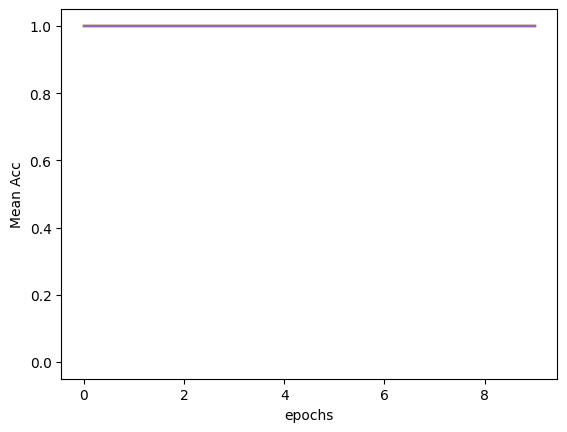

In [67]:
# Plot by epoch
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)
ax.set_xlabel("epochs")
ax.set_ylabel("Mean Acc")

In [73]:
device = "cuda" if torch.cuda.is_available else "cpu"

In [75]:
import os

logdir = results.get_best_result("mean_accuracy", mode="max").log_dir
state_dict = torch.load(os.path.join(logdir, "/content/models_state_dict.pth"))

model = Net()
model.to(device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [69]:
import matplotlib.pyplot as plt

Custom image tensor:
tensor([[[0.6902, 0.6902, 0.6902,  ..., 0.9843, 0.9804, 0.7843],
         [0.6863, 0.6824, 0.6863,  ..., 0.9647, 0.9961, 0.9333],
         [0.6824, 0.6745, 0.6824,  ..., 0.9647, 0.9882, 1.0000],
         ...,
         [0.2118, 0.2863, 0.2784,  ..., 0.4275, 0.2235, 0.1294],
         [0.3294, 0.3176, 0.2549,  ..., 0.4784, 0.2471, 0.1216],
         [0.3176, 0.3412, 0.2549,  ..., 0.4941, 0.3961, 0.1882]],

        [[0.8078, 0.8078, 0.8078,  ..., 0.9882, 0.9804, 0.7843],
         [0.8039, 0.8078, 0.8039,  ..., 0.9686, 0.9922, 0.9333],
         [0.8078, 0.8039, 0.8078,  ..., 0.9608, 0.9765, 0.9961],
         ...,
         [0.1765, 0.2471, 0.2353,  ..., 0.3608, 0.1529, 0.0588],
         [0.2824, 0.2784, 0.2118,  ..., 0.3961, 0.1647, 0.0471],
         [0.2706, 0.2941, 0.2118,  ..., 0.4000, 0.3137, 0.1059]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9882, 0.7922],
         [1.0000, 1.0000, 1.0000,  ..., 0.9765, 1.0000, 0.9412],
         [1.0000, 1.0000, 1.0000,  ..

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


'wINE'

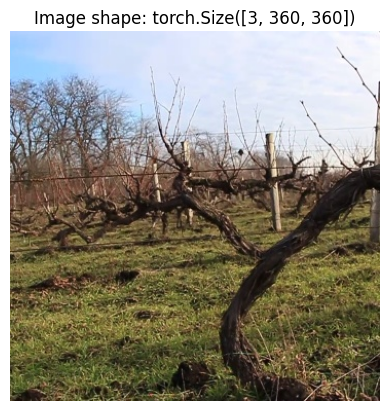

In [76]:
custom_image_path = image_path / "val/1/frame_10834.jpg" #  Class 1 - Winelose
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)
# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);
custom_image_transform = transforms.Compose([
    transforms.Resize((32, 32)),
])

custom_image_transformed = custom_image_transform(custom_image)

print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

model.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    
    # Make a prediction on image with an extra dimension
    custom_image_pred = model(custom_image_transformed.unsqueeze(dim=0).to(device))
    
    # Find the predicted label


# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

class_names = ['wINE', 'STAND']

custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

In [77]:
import random

In [79]:
image_path = Path('/content/WineYardDataset/Dataset')
data_transformation = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(size = (32, 32)),
     transforms.Normalize((0.1307, ), (0.3081, ))])

test_dir = image_path / "test"

test_data = datasets.ImageFolder(root = test_dir,
                                transform=data_transformation)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
test_dataloader = DataLoader(dataset=test_data, 
                            batch_size=BATCH_SIZE, 
                            num_workers=NUM_WORKERS, 
                            shuffle=False) # don't usually need to shuffle testing data
print(f"Создание DataLoaders с batch: {BATCH_SIZE} и workers: {NUM_WORKERS}.")


Создание DataLoaders с batch: 32 и workers: 2.


In [78]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:

      sample = torch.unsqueeze(sample, dim=0).to(device) 

      pred_logit = model(sample)

      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      pred_probs.append(pred_prob.cpu())
            
    return torch.stack(pred_probs)      

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


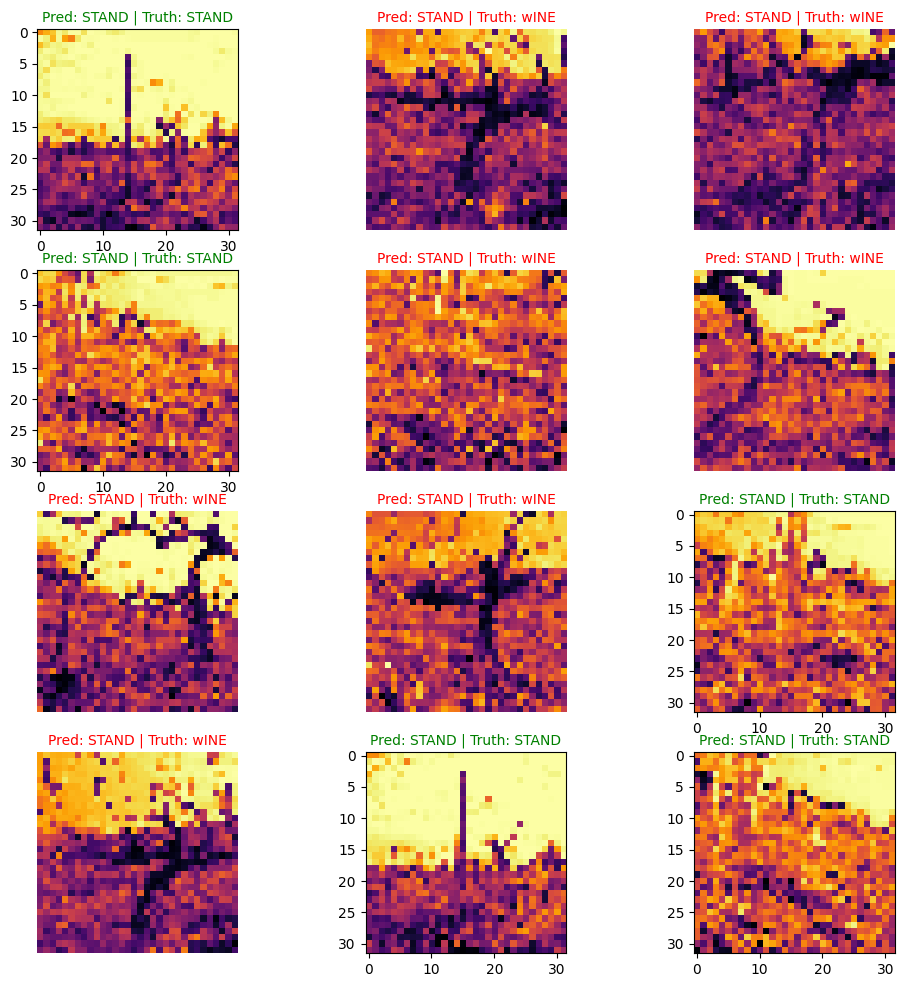

In [80]:
def plot_random_test_image(model: torch.nn.Module,
                           seed = 42,
                           n = 12,
                           test_data: torch.utils.data.dataset.Dataset = test_data,
                           device = "cpu"):
  random.seed(seed)
  test_samples = []
  test_labels = []
  for sample, label in random.sample(list(test_data), k=n):
      test_samples.append(sample)
      test_labels.append(label)

  pred_probs= make_predictions(model=model, data=test_samples, device=device)

  pred_classes = pred_probs.argmax(dim=1)

  plt.figure(figsize = (12, 12))

  nrows = 4
  ncols = 3

  for i in range(len(test_samples)):
    plt.subplot(nrows, ncols, i+1)
    img, label = test_samples[i][0], test_samples[i][1]
    plt.imshow(img, cmap = "inferno")
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]] 
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
    else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
      plt.axis(False)

plot_random_test_image(model_0, seed = 42, n = 12, test_data = test_data,  device = device)